<a href="https://colab.research.google.com/github/MaricelaMH/SIMULACION-II/blob/main/PRUEBA_ART_SIMU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install simpy

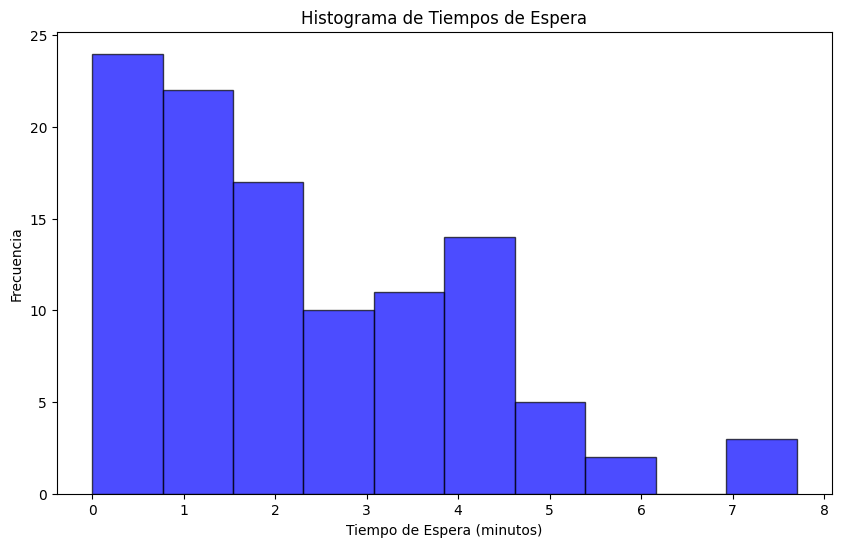

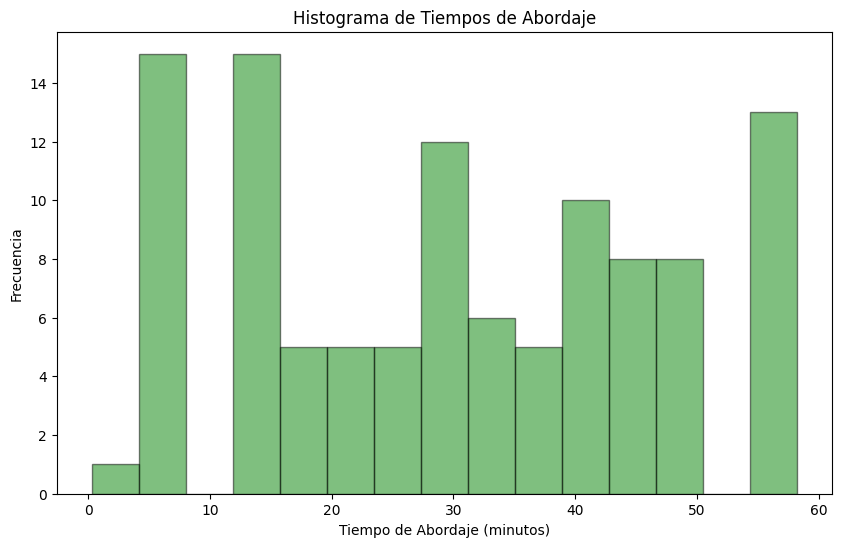

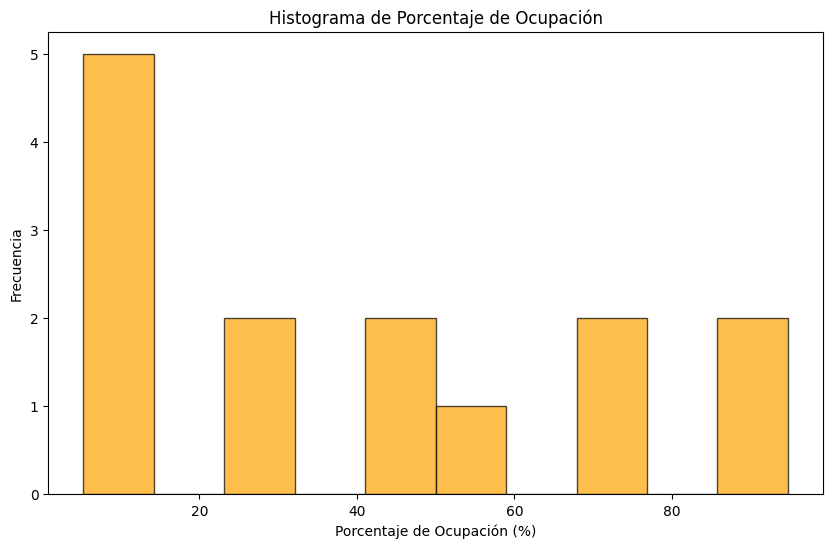

In [117]:
# prompt: por que no me genera el histograma de ocupación

import simpy
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del sistema
TASA_LLEGADAS_PROM = 0.62  # Pasajeros por minuto
TIEMPO_SERVICIO_PROM = 0.22  # Promedio de minutos para abordar un pasajero
NUM_COMBIS_BASE = 1  # Número base de combis fuera de los picos de demanda
CAPACIDAD_COMBI = 19  # Capacidad máxima de pasajeros por combi

# Registro de métricas
tiempos_llegada = []
tiempos_abordaje = []
ocupacion_combis = []

# Función para ajustar el número de combis según el intervalo de tiempo
def ajustar_combis(env, tiempo_actual):
    if 18 <= tiempo_actual <= 19:  # Intervalo de alta demanda (6:00 p.m. - 7:00 p.m.)
        return 3  # Aumentamos el número de combis en el intervalo pico
    else:
        return NUM_COMBIS_BASE  # Número estándar de combis fuera de los picos

# Función que simula el servicio de una combi (servidor)
def servicio_combi(env, combi_id, cola):
    capacidad = CAPACIDAD_COMBI
    pasajeros_atendidos = 0
    while True:
        # Esperar a que llegue un pasajero o que la capacidad se llene
        yield cola.get()
        tiempos_abordaje.append(env.now)  # Registro del tiempo de abordaje
        pasajeros_atendidos += 1
        capacidad -= 1

        # Si la capacidad de la combi es cero o la cola está vacía
        if capacidad == 0 or len(cola.items) == 0:
            ocupacion_combis.append(pasajeros_atendidos / CAPACIDAD_COMBI) #registrar ocupación
            pasajeros_atendidos = 0
            capacidad = CAPACIDAD_COMBI
            yield env.timeout(np.random.exponential(5))  # Tiempo antes de "salir"
        yield env.timeout(np.random.exponential(TIEMPO_SERVICIO_PROM))


# Función para generar la llegada de pasajeros
def llegada_pasajeros(env, cola):
    while True:
        tiempo_llegada = np.random.exponential(TASA_LLEGADAS_PROM)
        yield env.timeout(tiempo_llegada)
        tiempos_llegada.append(env.now)  # Registro del tiempo de llegada
        cola.put(1)

# Función para simular el sistema
def simulacion():
    env = simpy.Environment()
    cola = simpy.Store(env)  # Cola de pasajeros esperando

    # Iniciar la llegada de pasajeros
    env.process(llegada_pasajeros(env, cola))

    # Ajuste dinámico del número de combis
    num_combis = ajustar_combis(env, env.now)
    for i in range(num_combis):
        env.process(servicio_combi(env, i, cola))

    # Ejecutar la simulación por 60 minutos
    env.run(until=60)

    # Visualizar los resultados
    visualizar_histogramas()

# Función para visualizar los histogramas
def visualizar_histogramas():
    # Calcular tiempos de espera
    tiempos_espera = [abordaje - llegada for llegada, abordaje in zip(tiempos_llegada, tiempos_abordaje)]

    # Histograma de tiempos de espera
    plt.figure(figsize=(10, 6))
    plt.hist(tiempos_espera, bins=10, color='blue', edgecolor='black', alpha=0.7)
    plt.title("Histograma de Tiempos de Espera")
    plt.xlabel("Tiempo de Espera (minutos)")
    plt.ylabel("Frecuencia")
    plt.show()

    # Histograma de tiempos de abordaje
    plt.figure(figsize=(10, 6))
    plt.hist(tiempos_abordaje, bins=15, color='green', edgecolor='black', alpha=0.5)
    plt.title("Histograma de Tiempos de Abordaje")
    plt.xlabel("Tiempo de Abordaje (minutos)")
    plt.ylabel("Frecuencia")
    plt.show()

    # Histograma de porcentaje de ocupación
    plt.figure(figsize=(10, 6))
    plt.hist([min(ocupacion, 1.0) * 100 for ocupacion in ocupacion_combis], bins=10, color='orange', edgecolor='black', alpha=0.7)
    plt.title("Histograma de Porcentaje de Ocupación")
    plt.xlabel("Porcentaje de Ocupación (%)")
    plt.ylabel("Frecuencia")
    plt.show()

# Correr la simulación
simulacion()